# Model Mimarileri ve Matematiksel Temelleri

**Ders hedefleri**
- Lineer / doğrusal modelleri anlamak
- k-En Yakın Komşu (kNN) mimarisini ve mesafe kavramını anlamak
- Karar ağaçlarının çalışma mantığı ve impurity metriklerini anlamak

Denetimli (supervised) öğrenmede elimizde girdilerden oluşan $X$ matrisi ve bunlara ait hedef değerleri taşıyan $y$ vektörü vardır. Amaç, bu örneklerden hareketle yeni gelen örneklerin etiketini doğru tahmin edebilen bir fonksiyon öğrenmektir. Veriyi eğitim ve test olarak ayırmamızın sebebi, öğrenilen modelin görülmemiş verilere nasıl genelleştiğini ölçmektir.

Bu derste veri hazırlama detaylarından ziyade modellerin matematiksel omurgasına odaklanacağız. Sezgisel açıklamalarla başlayıp formüllerle derinleşecek, ardından aynı kavramları kodla deneyimleyeceğiz.


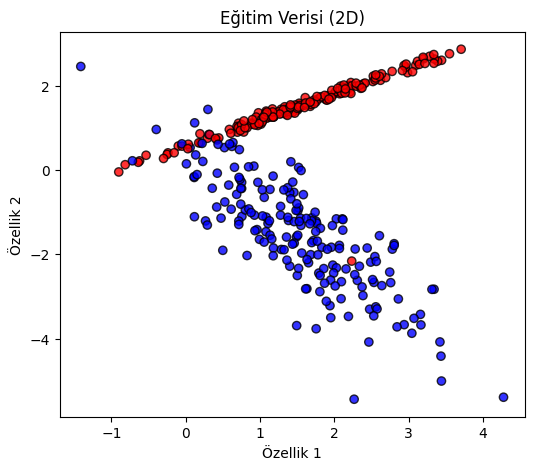

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(42)

X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.01,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k', alpha=0.8)
ax.set_xlabel('Özellik 1')
ax.set_ylabel('Özellik 2')
ax.set_title('Eğitim Verisi (2D)')
plt.show()


In [2]:
cmap_light = ListedColormap(['#FFEEEE', '#EEEEFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000AA'])


def plot_decision_regions(model, X, y, title, ax=None, h=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Özellik 1')
    ax.set_ylabel('Özellik 2')
    return ax


## 1. Bölüm – Lineer ve Lojistik Regresyonun Matematiği

**Sezgi:** Doğrusal modeller giriş özelliklerinin ağırlıklı toplamını alır ve bu toplamı (bias ekleyerek) karar vermek için kullanır. Bir hiper-düzlem, iki sınıfı ayıran karar sınırını temsil eder; ağırlıklar ($w$) düzlemin yönünü, bias ise konumunu belirler. Lojistik regresyonda bu doğrusal skor, sigmoid fonksiyonundan geçirilerek 0–1 aralığında olasılık yorumu yapılır. Loss fonksiyonu modelin yaptığı hataları ölçer; optimize ederken hedefimiz bu hatayı minimize ederek doğru sınıfa daha yüksek olasılık vermektir. Gradient descent de bu amaçla parametreleri küçük adımlarla güncelleyerek loss'u azaltmaya çalışır.


### Formüller
- Doğrusal hipotez: 

  $$ h_{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b $$

  Karar sınırı $ \mathbf{w}^\top \mathbf{x} + b = 0 $ doğrusu (2D'de) veya düzlemidir.
- Sigmoid fonksiyonu:

  $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

  Çıktı 0 ile 1 arasındadır ve sınıf 1 için olasılık olarak yorumlanır.
- Regresyon için Ortalama Kare Hata (MSE):

  $$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y^{(i)} - \hat{y}^{(i)})^2 $$
- İkili sınıflandırma için Binary Cross-Entropy (Log Loss):

  $$ \mathcal{L}_{\text{BCE}} = -\frac{1}{N} \sum_{i=1}^{N} \Big( y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \Big) $$
- Gradient descent sezgisi: Loss fonksiyonunun parametreler üzerindeki eğimine (türevinin işaretine) bakarız; eğimin ters yönüne küçük adımlarla giderek loss'u azaltır, böylece modelin daha az hata yapmasını sağlarız.


In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_test_acc = accuracy_score(y_test, log_reg.predict(X_test))
print(f"Logistic Regression test doğruluğu: {log_reg_test_acc:.3f}")


Logistic Regression test doğruluğu: 0.976


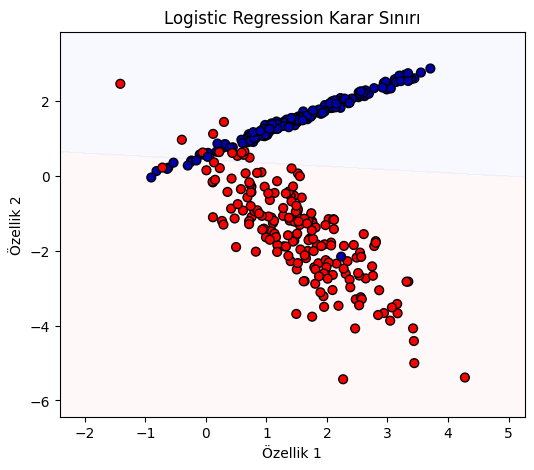

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_regions(log_reg, X_train, y_train, 'Logistic Regression Karar Sınırı', ax=ax)
plt.show()


Karar sınırının doğrusal olmasının sebebi modelin ağırlıkları sabit bir hiper-düzlem tanımlaması; sigmoid yalnızca bu doğrusal skorun olasılık yorumunu sağlar.


## 2. Bölüm – k-En Yakın Komşu (kNN) Matematiği ve Geometrisi

**Sezgi:** kNN eğitim sırasında parametre öğrenmez; tüm eğitim verisini hafızada tutar. Yeni bir nokta geldiğinde, bu noktanın uzaydaki en yakın komşularına bakarak sınıf tahmini yapar. Bu yüzden parametrik bir model değildir; karar sınırı doğrudan verinin geometrisine bağlıdır. Parametrik modeller (ör. lojistik regresyon) sınırlı sayıda ağırlık öğrenirken, parametrik olmayan kNN veri büyüdükçe karmaşıklığı artan esnek sınırlar çizer.


### Mesafe Metrikleri
- Öklidyen mesafe (L2):

  $$ d_{\text{Öklid}}(\mathbf{x}, \mathbf{z}) = \sqrt{\sum_{j=1}^{n} (x_j - z_j)^2} $$
- Manhattan mesafesi (L1):

  $$ d_{\text{Manhattan}}(\mathbf{x}, \mathbf{z}) = \sum_{j=1}^{n} |x_j - z_j| $$

Öklidyen mesafe sürekli, düzgün dağılımlarda sezgisel olarak dairesel komşuluklar tanımlar; Manhattan mesafesi ise özellikle ızgara-benzeri veya eksenlere hizalı yolların anlamlı olduğu durumlarda daha uygun olabilir.


In [5]:
toy_X = np.array([
    [0.1, 0.2],
    [0.2, 0.8],
    [0.3, 0.4],
    [0.8, 0.5],
    [0.9, 0.1],
    [0.6, 0.9],
    [0.4, 0.7],
    [0.7, 0.2]
])

toy_y = np.array([0, 1, 0, 1, 1, 1, 0, 0])


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


class SimpleKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, x):
        distances = np.array([euclidean_distance(x, point) for point in self.X_train])
        neighbor_idx = np.argsort(distances)[: self.k]
        neighbor_labels = self.y_train[neighbor_idx]
        values, counts = np.unique(neighbor_labels, return_counts=True)
        return values[np.argmax(counts)]


test_points = np.array([
    [0.15, 0.3],
    [0.75, 0.4],
    [0.55, 0.85]
])

simple_knn = SimpleKNN(k=3)
simple_knn.fit(toy_X, toy_y)
for point in test_points:
    pred = simple_knn.predict(point)
    print(f"Nokta {point} için tahmin: {pred}")


Nokta [0.15 0.3 ] için tahmin: 0
Nokta [0.75 0.4 ] için tahmin: 1
Nokta [0.55 0.85] için tahmin: 1


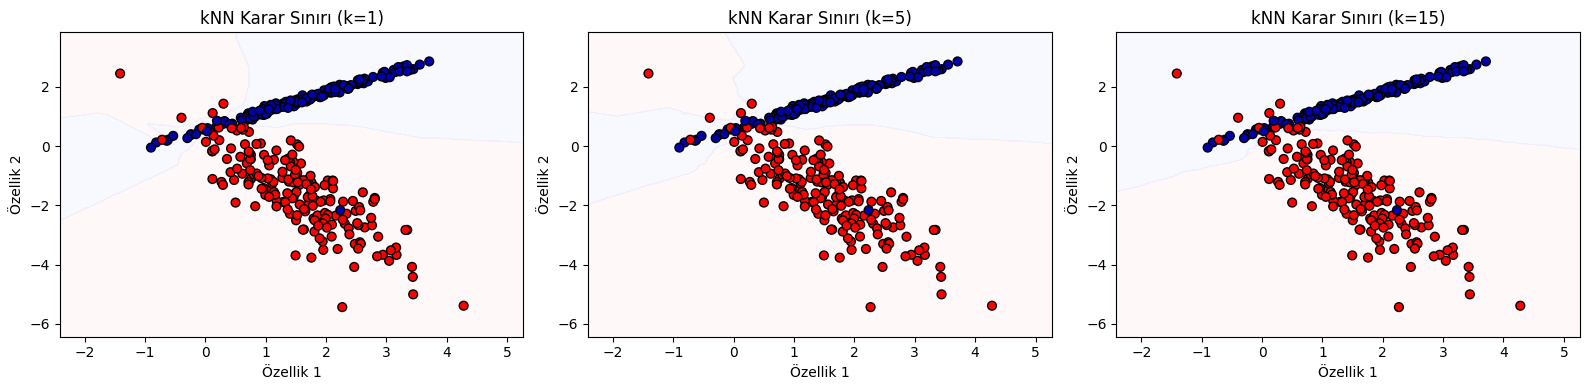

<Figure size 640x480 with 0 Axes>

In [14]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 5, 15]
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for k, ax in zip(k_values, axes):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    plot_decision_regions(knn, X_train, y_train, f'kNN Karar Sınırı (k={k})', ax=ax)

plt.tight_layout()
plt.show()
plt.savefig('knn_decision_boundaries.png')


- k=1 iken karar sınırı çok detaylı ve pürüzlü; model her noktayı ezberlediğinden overfit riski yüksektir.
- k=5 orta düzeyde yumuşaklık sağlar; yerel komşuluklar dikkate alınırken gürültü azaltılır.
- k=15 ise sınırı aşırı düzleştirir; ince yapıları kaçırma pahasına daha düzgün (ve potansiyel olarak underfit) kararlar üretir.


## 3. Bölüm – Karar Ağaçları ve Impurity Metrikleri

**Sezgi:** Karar ağaçları, özelliklere göre ardışık sorular sorarak veriyi bölümlere ayırır. Her düğümde belirli bir özellik üzerinde eşik seçilir; bu eşik, sınıfları mümkün olduğunca saf alt gruplara ayırmayı hedefler. Yaprak düğümlerde çoğunluk sınıfı tahmin edilir. Hangi soruyu soracağımıza impurity (karışıklık) metrikleri karar verir.


### Entropi ve Gini
- Entropi:

  $$ H(S) = - \sum_{c} p_c \log_2 p_c $$

  5 pozitif, 3 negatif örnek için $p_+ = 5/8$, $p_- = 3/8$ olur ve 

  $$ H = -\left( \tfrac{5}{8} \log_2 \tfrac{5}{8} + \tfrac{3}{8} \log_2 \tfrac{3}{8} \right) \approx 0.954 $$
- Gini:

  $$ G(S) = 1 - \sum_{c} p_c^2 $$

  Aynı örnek için $ G = 1 - ((5/8)^2 + (3/8)^2) = 0.469 $.

Her iki metrik de karışıklığı ölçer; entropi logaritma içerdiği için biraz daha maliyetlidir ama bilgi teorisi yorumu sunar. Gini ise kareler kullandığından daha hızlıdır ve pratikte benzer sıralamalar verir.


### Information Gain
Bilgi kazancı, bölme öncesi impurity ile bölme sonrası ağırlıklı impurity arasındaki farktır:

$$ IG = I(\text{parent}) - \sum_{k} \frac{|S_k|}{|S|} I(S_k) $$

Örnek: 10 gözlem (6 pozitif, 4 negatif) için entropi $H_{parent} \approx 0.971$. Bir eşik veriyi ikiye ayırsın: sol dalda 5 örnek (4 pozitif, 1 negatif, $H_{sol} \approx 0.722$), sağ dalda 5 örnek (2 pozitif, 3 negatif, $H_{sağ} \approx 0.971$).

$$ IG = 0.971 - \left( \tfrac{5}{10} \cdot 0.722 + \tfrac{5}{10} \cdot 0.971 \right) = 0.971 - 0.846 = 0.125 $$

Yani bu split, düğümdeki belirsizliği 0.125 kadar azaltır; daha yüksek IG daha iyi split demektir.


In [7]:
def entropy_from_counts(pos_count, neg_count):
    total = pos_count + neg_count
    if total == 0:
        return 0.0
    probs = [pos_count / total, neg_count / total]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy


def gini_from_counts(pos_count, neg_count):
    total = pos_count + neg_count
    if total == 0:
        return 0.0
    probs = [pos_count / total, neg_count / total]
    gini = 1 - sum(p ** 2 for p in probs)
    return gini


scenarios = [
    ('%50 - %50', 4, 4),
    ('%90 - %10', 9, 1),
    ('%70 - %30', 7, 3)
]

for name, pos, neg in scenarios:
    print(f"{name} dağılımı -> Entropi: {entropy_from_counts(pos, neg):.3f}, Gini: {gini_from_counts(pos, neg):.3f}")


%50 - %50 dağılımı -> Entropi: 1.000, Gini: 0.500
%90 - %10 dağılımı -> Entropi: 0.469, Gini: 0.180
%70 - %30 dağılımı -> Entropi: 0.881, Gini: 0.420


Ağaç derinliği: 10
Yaprak sayısı: 21


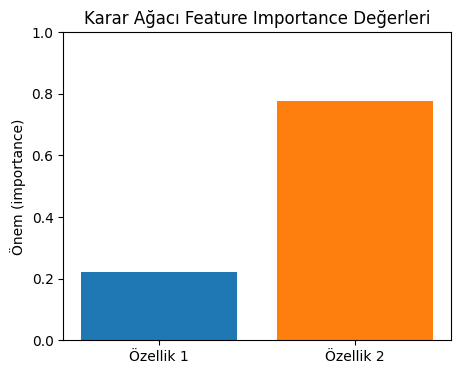

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_clf.fit(X_train, y_train)

print(f"Ağaç derinliği: {tree_clf.get_depth()}")
print(f"Yaprak sayısı: {tree_clf.get_n_leaves()}")

feature_names = ['Özellik 1', 'Özellik 2']
importances = tree_clf.feature_importances_

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(feature_names, importances, color=['#1f77b4', '#ff7f0e'])
ax.set_ylim(0, 1)
ax.set_ylabel('Önem (importance)')
ax.set_title('Karar Ağacı Feature Importance Değerleri')
plt.show()


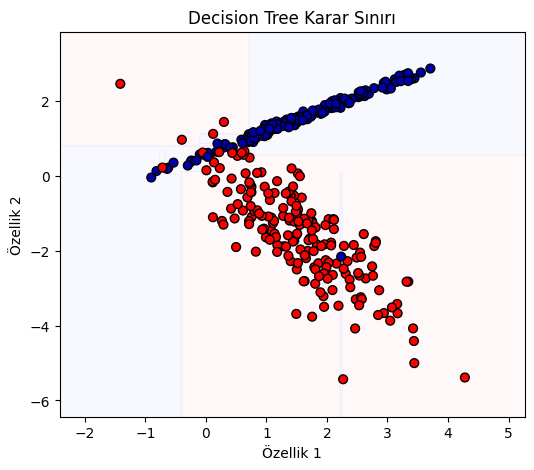

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_regions(tree_clf, X_train, y_train, 'Decision Tree Karar Sınırı', ax=ax)
plt.show()


Karar ağacının karar sınırı blok-blok ilerler; çünkü her split tek bir özelliği eşikleyen dikdörtgensel bölgeler üretir. Bu yapı, lojistik regresyonun düz çizgileri ve kNN'nin serbest biçimli sınırlarıyla görsel olarak ayrışır.


## 4. Bölüm – Mimari Karşılaştırma ve Mini Egzersizler

| Model | Lineer mi? | Parametrik mi? | Eğitim karmaşıklığı | Tahmin süresi | Avantajları | Dezavantajları |
| --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | Evet | Evet | Düşük | Çok hızlı | Yorumlanabilir ağırlıklar, lineer karar sınırları | Doğrusal olmayan desenleri yakalamakta zorlanır |
| kNN | Hayır | Hayır | Eğitimi yok (sadece saklama) | Daha yavaş (tüm veriyle mesafe) | Veri geometrisine uyumlu esnek sınırlar | Büyük veriyle maliyetli, ölçekleme hassas |
| Decision Tree | Hayır (parça-wise) | Genelde parametrik değil | Orta | Hızlı | Nonlineer ilişkileri yakalar, açıklanabilir yapılar | Gürültüye duyarlı, derin ağaçlar overfit edebilir |


In [10]:
models = {
    'Logistic Regression': LogisticRegression(),
    'kNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results.append({'Model': name, 'Test Doğruluğu': acc})

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Test Doğruluğu
0  Logistic Regression           0.976
1            kNN (k=5)           0.960
2        Decision Tree           0.960


### TODO 1
kNN için farklı mesafe metriklerini (örneğin Manhattan) dene ve karar sınırlarını karşılaştır.


In [11]:
# TODO 1: Buraya kendi denemeni ekle


### TODO 2
Karar ağacına `max_depth` parametresi ekleyerek farklı derinlikler için overfit/underfit davranışını gözlemle.


In [12]:
# TODO 2: Buraya kendi denemeni ekle


### TODO 3
Logistic Regression'da `C` parametresini değiştirerek regularizasyon gücünün karar sınırına ve accuracy'ye etkisini incele.


In [13]:
# TODO 3: Buraya kendi denemeni ekle


## Özet
Lineer modeller ağırlıklarla tanımlanan düz karar sınırları üretir ve parametriktir; kNN parametrik olmayan, veri büyüdükçe karmaşıklaşan esnek sınırlar çizer; karar ağaçları ise özelliğe bağlı sorularla uzayı bloklara ayırır. Parametrik modeller az sayıda parametreyle genelleme yaparken, parametrik olmayan modeller veriyi hafızada tutarak daha esnek fakat daha maliyetli kararlar verir. Gerçek projelerde aynı veri üzerinde farklı mimariler denememizin nedeni, her modelin farklı varsayımlar taşıması ve belirli veri geometrilerinde diğerlerinden daha güçlü performans gösterebilmesidir.
